# Test Cross Power Spectrum

In this notebook, the cross power spectrum between the DR9 galaxy density and Galactic extinction map is investigated. 

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import healpy as hp
from healpy.rotator import Rotator
import fitsio as ft
import matplotlib.pyplot as plt
import sys
sys.path.append('/users/PHS0336/medirz90/github/LSSutils')
from lssutils.lab import AnaFast
import lssutils.utils as ut
from lssutils.dataviz import setup_color
import h5py

In [3]:
from time import time

In [4]:
setup_color()

## Other Extinction maps 
Lenz et al. 2017 (from HI4PI data and the SFD 2003 reddening map) and Green et al. 2019 (derived from PanSTARRS1 and 2MASS stellar photometry and Gaia stellar parallaxes)    
https://lambda.gsfc.nasa.gov/product/foreground/fg_ebv_2017_map_get.cfm    
https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/2EJ9TX    

_"three-dimensional map of dust reddening, covering the three quarters of the sky surveyed by the Pan-STARRS 1 (PS1) survey (declination δ > -30°). We use PS1 and 2MASS optical and near-infrared photometry, in conjunction with Gaia DR2 parallaxes, to infer distances and reddenings to ~800 million stars. These stars trace the reddening along different lines of sight, allowing us to build up a map of reddening in 3D. "_    
Read http://argonaut.skymaps.info/usage#intro for how this map can be translated to E[B-V]

In [5]:
def read_lenz():
    """ read Lenz et al. (2017) 
    
    """
    ebv_l = ft.read('/fs/ess/PHS0336/data/templates/ebv_lhd.hpx.fits', columns='EBV')
    rt = Rotator(coord=['G', 'C'])
    ebv_lhd = rt.rotate_map_pixel(ebv_l)   
    return ebv_lhd

def read_green():
    """ read Green et al. (2019) 
    
    """
    bayestar = h5py.File('/fs/ess/PHS0336/data/templates/bayestar2019.h5', 'r')
    pix_info = bayestar['/pixel_info'][:]
    EBV_far_median = np.median(bayestar['/samples'][:,:,-1], axis=1)
    bayestar.close()
    
    # Construct an empty map at the highest HEALPix resolution present in the map
    nside_max = np.max(pix_info['nside'])
    n_pix = hp.pixelfunc.nside2npix(nside_max)
    pix_val = np.empty(n_pix, dtype='f8')
    pix_val[:] = np.nan
    
    # Fill the upsampled map
    for nside in np.unique(pix_info['nside']):
        # Get indices of all pixels at current nside level
        idx = pix_info['nside'] == nside

        # Extract E(B-V) of each selected pixel
        pix_val_n = EBV_far_median[idx]

        # Determine nested index of each selected pixel in upsampled map
        mult_factor = int((nside_max/nside)**2)
        pix_idx_n = pix_info['healpix_index'][idx] * mult_factor

        # Write the selected pixels into the upsampled map
        for offset in range(mult_factor):
            pix_val[pix_idx_n+offset] = pix_val_n[:]

    rt = Rotator(coord=['G', 'C'])
    ebv_green = rt.rotate_map_pixel(hp.reorder(pix_val, n2r=True))        
    return ebv_green*0.884 # http://argonaut.skymaps.info/usage#intro

In [6]:
ebv_lenz = read_lenz()
ebv_green = read_green()

/users/PHS0336/medirz90/miniconda3/envs/sysnet/lib/python3.8/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/users/PHS0336/medirz90/miniconda3/envs/sysnet/lib/python3.8/site-packages/healpy/projaxes.py:1184: RuntimeWarning: invalid value encountered in less
  result.data[result.data < 0] = 0.0
/users/PHS0336/medirz90/miniconda3/envs/sysnet/lib/python3.8/site-packages/healpy/projaxes.py:1185: RuntimeWarning: invalid value encountered in greater
  result.data[result.data > 1] = 1.0


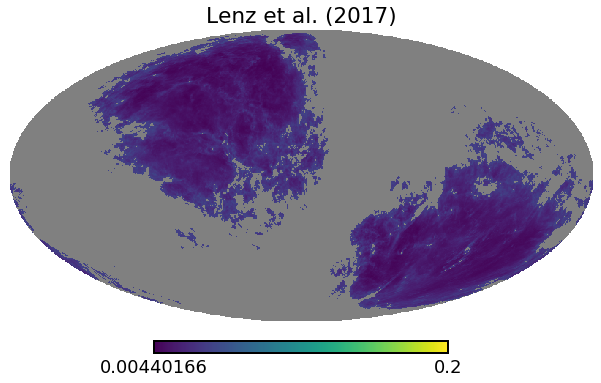

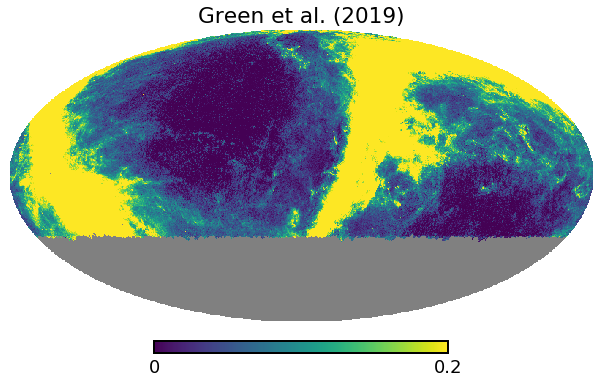

In [7]:
#plt.figure(figsize=(6, 3.5))
hp.mollview(ebv_lenz, rot=(130, 0), title='Lenz et al. (2017)', max=0.2)
hp.mollview(ebv_green, rot=(130, 0), title='Green et al. (2019)', max=0.2)

In [8]:
def run_cl2(region):
    
    t0 = time()
    
    # dr9 data
    nside = 1024

    path = '/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/'
    data = ft.read(f'{path}nelg_features_{region}_{nside}.fits')

    ngal = ut.make_hp(nside, data['hpix'], data['label'])
    frac = ut.make_hp(nside, data['hpix'], data['fracgood'])
    mask = ut.make_hp(nside, data['hpix'], 1.0) > 0.5
    
    ebv_ran = ut.make_hp(nside, data['hpix'], data['features'][:, 0])

    maskt = mask & np.isfinite(ebv_green)

    # density contrast for E[B-V]
    delta_ebvr = ut.make_overdensity(ebv_ran, frac, maskt, is_sys=True)
    delta_ebvg = ut.make_overdensity(ebv_green, frac, maskt, is_sys=True)
    
    delta_g = ut.make_overdensity(ngal, frac, maskt)

    af = AnaFast()
    lbins = np.arange(1, 1100, 11) # or 51
    
    cl_ebv = {}
    cl_ebv['ebv randoms'] = ut.histogram_cell(af(delta_g, frac, maskt, delta_ebvr, frac, maskt)['cl'], 
                                              bins=lbins)
    cl_ebv['ebv green'] = ut.histogram_cell(af(delta_g, frac, maskt, delta_ebvg, frac, maskt)['cl'], 
                                              bins=lbins)
    
    print(region, maskt.sum()/mask.sum(), time()-t0)
    return cl_ebv

In [9]:
cl_sg = {}
for reg in ['bmzls', 'ndecals', 'sdecals']:
    cl_sg[reg] = run_cl2(reg)
    
np.savez('./cl_sg_green_sfd.npz', **cl_sg)

bmzls 1.0 151.1861765384674
ndecals 0.9999921962182874 151.01675057411194
sdecals 0.999991929928724 151.1516592502594


In [11]:
def run_cl(region):
    
    t0 = time()
    
    # dr9 data
    nside = 1024

    path = '/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/'
    data = ft.read(f'{path}nelg_features_{region}_{nside}.fits')

    ngal = ut.make_hp(nside, data['hpix'], data['label'])
    frac = ut.make_hp(nside, data['hpix'], data['fracgood'])
    mask = ut.make_hp(nside, data['hpix'], 1.0) > 0.5
    
    ebv_ran = ut.make_hp(nside, data['hpix'], data['features'][:, 0])

    maskt = mask & np.isfinite(ebv_lenz) & np.isfinite(ebv_green)

    # density contrast for E[B-V]
    delta_ebvr = ut.make_overdensity(ebv_ran, frac, maskt, is_sys=True)
    delta_ebvl = ut.make_overdensity(ebv_lenz, frac, maskt, is_sys=True)
    delta_ebvg = ut.make_overdensity(ebv_green, frac, maskt, is_sys=True)
    
    delta_g = ut.make_overdensity(ngal, frac, maskt)

    af = AnaFast()
    lbins = np.arange(1, 1100, 11) # or 51
    
    cl_ebv = {}
    cl_ebv['ebv randoms'] = ut.histogram_cell(af(delta_g, frac, maskt, delta_ebvr, frac, maskt)['cl'], 
                                              bins=lbins)
    cl_ebv['ebv lenz'] = ut.histogram_cell(af(delta_g, frac, maskt, delta_ebvl, frac, maskt)['cl'], 
                                           bins=lbins)
    cl_ebv['ebv green'] = ut.histogram_cell(af(delta_g, frac, maskt, delta_ebvg, frac, maskt)['cl'], 
                                              bins=lbins)
    
    print(region, maskt.sum()/mask.sum(), time()-t0)
    return cl_ebv

In [12]:
cl_sg2 = {}
for reg in ['bmzls', 'ndecals', 'sdecals']:
    cl_sg2[reg] = run_cl(reg)
np.savez('./cl_sg_lenz_green_sfd.npz', **cl_sg2)

bmzls 0.7651435711801307 230.43424344062805
ndecals 0.7525978231908326 230.42233991622925
sdecals 0.4944503849135782 230.52704191207886


In [14]:
def make_plot(filename):
    cl_ebvs = np.load(filename, allow_pickle=True)

    regs = ['bmzls', 'ndecals', 'sdecals']

    fg, ax = plt.subplots(ncols=3, figsize=(15, 4), sharey=True)
    fg.subplots_adjust(wspace=0.0)

    for i, reg_j in enumerate(regs):

        cl_j = cl_ebvs[reg_j].item()

        for n_i, cl_i in cl_j.items():
            ax[i].plot(*cl_i, label=n_i.upper())

        ax[i].axhline(0.0, lw=1, alpha=0.2)
        ax[0].set_xlabel(r'$\ell$')
        ax[i].text(0.1, 0.9, reg_j, transform=ax[i].transAxes)


    ax[0].set_yscale('symlog', linthreshy=1.0e-8)
    ax[0].set_ylim(-1.0e-3, 1.0e-3)
    ax[1].set_title(r'C$_{g,EBV}$')
    ax[2].legend()
    # plt.xscale('log')
    
    

    regs = ['bmzls', 'ndecals', 'sdecals']


    fg, ax = plt.subplots(ncols=3, figsize=(15, 4), sharey=True)
    fg.subplots_adjust(wspace=0.0)

    for i, reg_j in enumerate(regs):

        cl_j = cl_ebvs[reg_j].item()    
        for n_i, cl_i in cl_j.items():
            ax[i].plot(cl_i[0], abs(cl_i[1])/abs(cl_j['ebv randoms'][1]), label=n_i.upper())

        ax[0].set_xlabel(r'$\ell$')
        ax[i].text(0.1, 0.9, reg_j, transform=ax[i].transAxes)


    ax[1].set_title(r'absolute C$_{g,EBV}$ ratio')
    ax[2].legend()
    ax[0].set_ylim(0., 20.0)

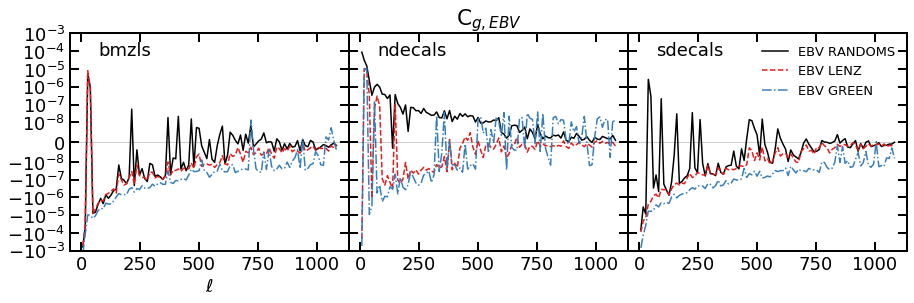

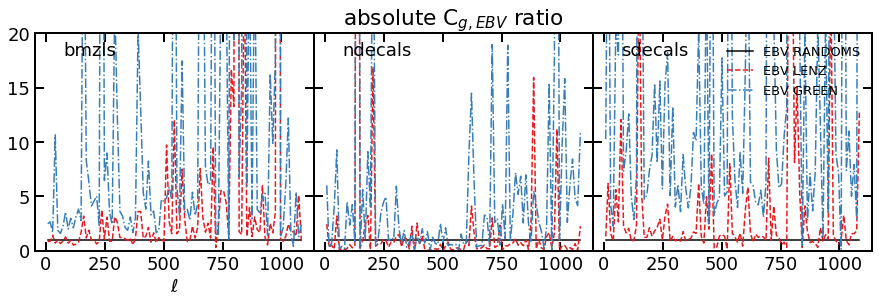

In [15]:
make_plot('./cl_sg_lenz_green_sfd.npz')

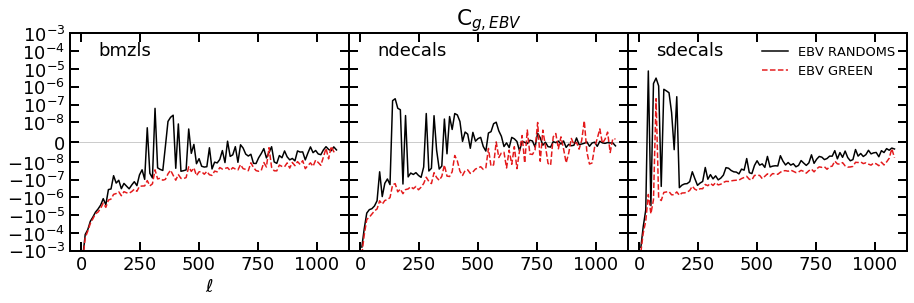

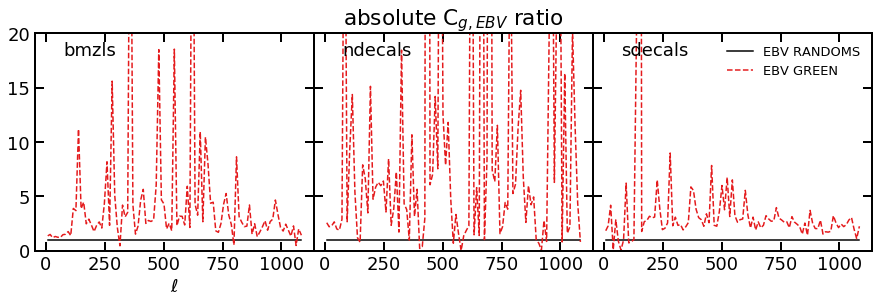

In [16]:
make_plot('./cl_sg_green_sfd.npz')

## Effect of footprint masking

In [17]:
region = 'bmzls'

# dr9 data
nside = 1024

data = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/nelg_features_{region}_1024.fits')

ngal = ut.make_hp(nside, data['hpix'], data['label'])
frac = ut.make_hp(nside, data['hpix'], data['fracgood'])
mask = ut.make_hp(nside, data['hpix'], 1.0) > 0.5
ebv_ran = ut.make_hp(nside, data['hpix'], data['features'][:, 0])

maskt = mask & np.isfinite(ebv_lenz) & np.isfinite(ebv_green)




af = AnaFast()
lbins = np.arange(1, 1100, 11) # or 51

delta_ebvr = ut.make_overdensity(ebv_ran, frac, mask, is_sys=True)
delta_g = ut.make_overdensity(ngal, frac, mask)
cl_full = ut.histogram_cell(af(delta_g, frac, mask, 
                              delta_ebvr, frac, mask)['cl'], bins=lbins)


delta_ebvr = ut.make_overdensity(ebv_ran, frac, maskt, is_sys=True)
delta_g = ut.make_overdensity(ngal, frac, maskt)
cl_partial = ut.histogram_cell(af(delta_g, frac, maskt, 
                               delta_ebvr, frac, maskt)['cl'], bins=lbins)

print(maskt.sum()/mask.sum())

0.7651435711801307


Text(0, 0.5, 'C$_{g, EBV}$')

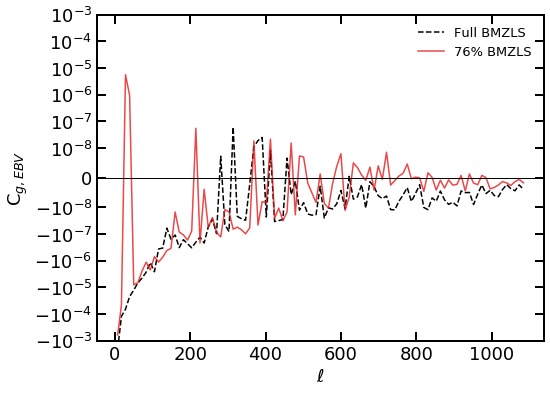

In [18]:
plt.figure(figsize=(8, 6))
plt.plot(*cl_full, 'C0--')
plt.plot(*cl_partial, 'C1-', alpha=0.8)
plt.legend(['Full BMZLS', '76% BMZLS'])
plt.yscale('symlog', linthreshy=1.0e-8)
# plt.ylim(-1.0e-2, 1.0e-4)
plt.ylim(-1.0e-3, 1.0e-3)
plt.axhline(0, lw=1)
plt.xlabel(r'$\ell$')
plt.ylabel(r'C$_{g, EBV}$')

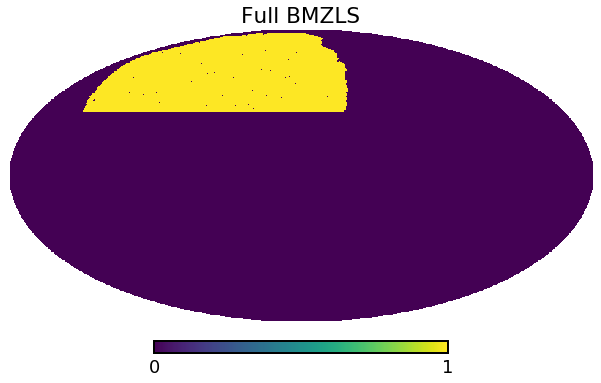

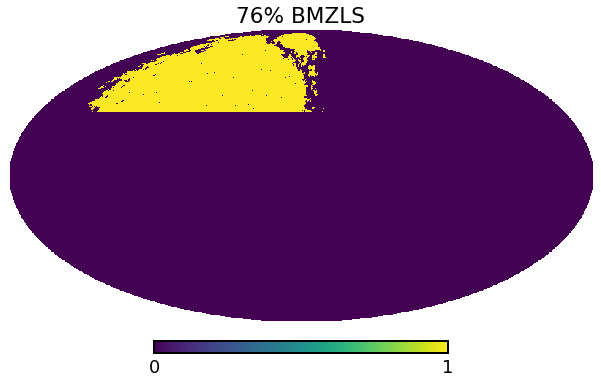

In [20]:
hp.mollview(mask, rot=(130, 0), title='Full BMZLS')
hp.mollview(maskt, rot=(130, 0), title='76% BMZLS')

## NASA Lambda Map

https://lambda.gsfc.nasa.gov/product/foreground/fg_ebv_map.cfm

NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT


/users/PHS0336/medirz90/miniconda3/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:403: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


Ordering converted to RING


/users/PHS0336/medirz90/miniconda3/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:351: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(


NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


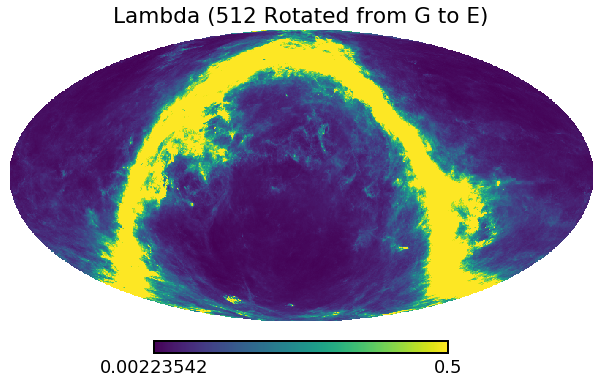

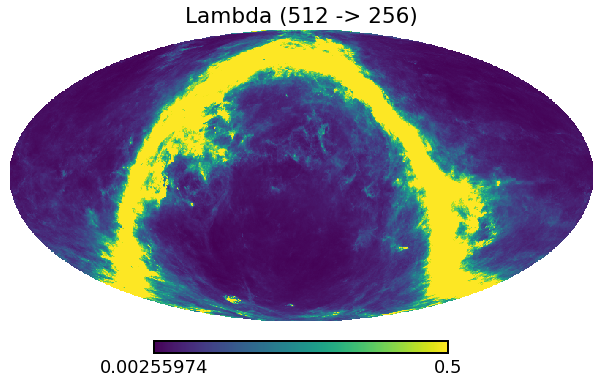

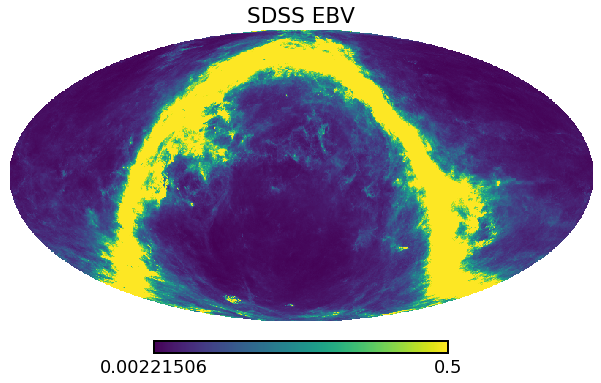

In [5]:
# read Lambda E[B-V] map
# nside=512, original in galactic
ebv_ = hp.read_map('/fs/ess/PHS0336/data/templates/lambda_sfd_ebv.fits', dtype=np.float32)
rt = Rotator(coord=['G', 'C'])
lambda_ebv = rt.rotate_map_pixel(ebv_)
lambda_ebv256 = hp.ud_grade(lambda_ebv, 256)


# dr9 data
data = ft.read('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/nelg_features_bmzls_256.fits')
ngal = ut.make_hp(256, data['hpix'], data['label'])
frac = ut.make_hp(256, data['hpix'], data['fracgood'])
mask = ut.make_hp(256, data['hpix'], 1.0) > 0.5
random_ebv = ut.make_hp(256, data['hpix'], data['features'][:, 0])


# SDSS SFD map
# in NSIDE=256
sfd_old = hp.read_map('/fs/ess/PHS0336/data/templates/healSFD_256_fullsky.fits')

hp.mollview(lambda_ebv, max=0.5, title='Lambda (512 Rotated from G to E)')
hp.mollview(lambda_ebv256, max=0.5, title='Lambda (512 -> 256)')
hp.mollview(sfd_old, max=0.5, title='SDSS EBV')

In [23]:
from scipy.stats import pearsonr, spearmanr

0.9988076948772042 0.9985706977760417 
0.9993958452545167 0.9995704431530712 


Text(0, 0.5, 'Randoms EBV')

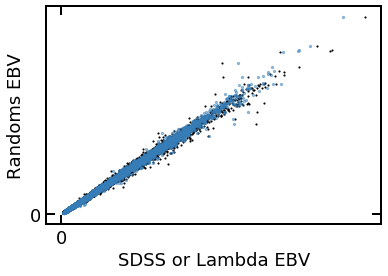

In [27]:
def plot_scatter(x, y, **kw):
    for cf in [pearsonr, spearmanr]:
        print(cf(x, y)[0], end=' ')
    plt.scatter(x, y, 5, **kw)
    print()

plot_scatter(sfd_old[mask], random_ebv[mask], marker='.', label='SDSS')
plot_scatter(lambda_ebv256[mask], random_ebv[mask], marker='o', label='Lambda', alpha=0.5)
plt.xscale('symlog', linthreshx=0.5)
plt.yscale('symlog', linthreshy=0.5)
plt.xlabel('SDSS or Lambda EBV')
plt.ylabel('Randoms EBV')

In [18]:
frac5 = hp.ud_grade(frac, 512)
mask5 = hp.ud_grade(mask, 512)
ngal5 = hp.ud_grade(ngal, 512, power=-2)
print(ngal[mask].sum(), ngal5[mask5].sum())

11288643.0 11288643.0


In [19]:
delta_lebv5 = ut.make_overdensity(lambda_ebv, frac5, mask5, is_sys=True)
delta_lebv = ut.make_overdensity(lambda_ebv256, frac, mask, is_sys=True)
delta_sebv = ut.make_overdensity(sfd_old, frac, mask, is_sys=True)
delta_rebv = ut.make_overdensity(random_ebv, frac, mask, is_sys=True)

delta_g = ut.make_overdensity(ngal, frac, mask)
delta_g5 = ut.make_overdensity(ngal5, frac5, mask5)

In [20]:
af = AnaFast()

In [21]:
cl_ebv = {}
cl_ebv['lambda[512]'] = af(delta_lebv5, frac5, mask5)
cl_ebv['lambda'] = af(delta_lebv, frac, mask)
cl_ebv['sdss'] = af(delta_sebv, frac, mask)
cl_ebv['randoms'] = af(delta_rebv, frac, mask)

Text(0, 0.5, 'C$_{\\ell}$/C$_{SDSS}$')

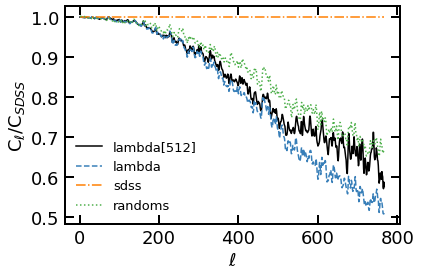

In [22]:
for n_i, cl_i in cl_ebv.items():
    plt.plot(cl_i['l'][1:768], cl_i['cl'][1:768]/cl_ebv['sdss']['cl'][1:768], label=f'{n_i}')
plt.legend()
plt.xlabel(r'$\ell$')
plt.ylabel(r'C$_{\ell}$/C$_{SDSS}$')
# plt.yscale('log')

In [28]:
def read_bin(clfile):
    lbins = np.arange(1, 1100, 11) # or 51
    cl_ = np.load(clfile, allow_pickle=True).item()
    lb, clb = ut.histogram_cell(cl_['cl_sg'][0]['cl'], bins=lbins)
    return (lb, clb)

In [29]:
lbins = np.arange(1, 1100, 11) # or 51
cl_lsg = af(delta_g, frac, mask, delta_lebv, frac, mask)
cl_lsg5 = af(delta_g5, frac5, mask5, delta_lebv5, frac5, mask5)

/users/PHS0336/medirz90/github/LSSutils/lssutils/utils.py:1057: RuntimeWarning: invalid value encountered in true_divide
  cell_bin = cell_weights_bin / weights_bin
/users/PHS0336/medirz90/github/LSSutils/lssutils/utils.py:1058: RuntimeWarning: invalid value encountered in true_divide
  ell_bin = ell_weights_bin / weights_bin


In [ ]:
cl_data = {}
cl_data['lambda ebv [256]'] = ut.histogram_cell(cl_lsg['cl'], bins=lbins)
cl_data['lambda ebv [512]'] = ut.histogram_cell(cl_lsg5['cl'], bins=lbins)
cl_data['randoms ebv [256]'] = read_bin('/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/v2/cl_elg_bmzls_256_noweight.npy')
cl_data['randoms ebv [1024]'] = read_bin('/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/v2/cl_elg_bmzls_1024_noweight.npy')

Text(0.5, 1.0, 'C$_{g,Lambda~or~Randoms~EBV}$')

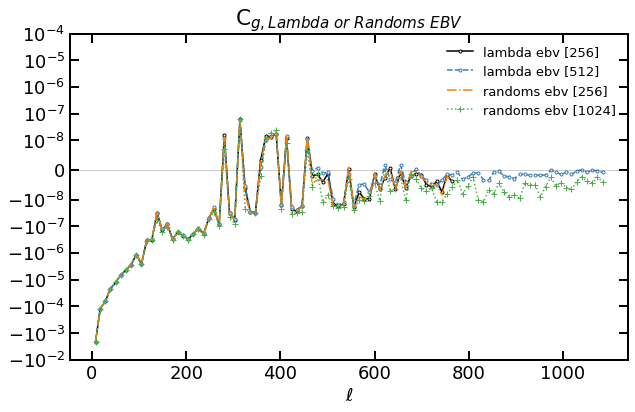

In [30]:
mk = ['.', '.', 'None', '+']
i = 0

plt.figure(figsize=(10, 6))
for n_i, cl_i in cl_data.items():
    plt.plot(*cl_i, label=n_i, marker=mk[i], mfc='w')
    i += 1
    
plt.yscale('symlog', linthreshy=1.0e-8)
plt.ylim(-1.0e-2, 1.0e-4)
plt.legend()
plt.axhline(0.0, lw=1, alpha=0.2)
plt.xlabel(r'$\ell$')
plt.title(r'C$_{g,Lambda~or~Randoms~EBV}$')
# plt.xscale('log')

In [31]:
cl_data['randoms ebv [256]'] = read_bin('/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/v2/cl_elg_bmzls_256_nn.npy')
cl_data['randoms ebv [1024]'] = read_bin('/fs/ess/PHS0336/data/rongpu/imaging_sys/clustering/v2/cl_elg_bmzls_1024_nn.npy')

/users/PHS0336/medirz90/github/LSSutils/lssutils/utils.py:1057: RuntimeWarning: invalid value encountered in true_divide
  cell_bin = cell_weights_bin / weights_bin
/users/PHS0336/medirz90/github/LSSutils/lssutils/utils.py:1058: RuntimeWarning: invalid value encountered in true_divide
  ell_bin = ell_weights_bin / weights_bin


Text(0.5, 1.0, 'C$_{g,Lambda~or~Randoms~EBV}$')

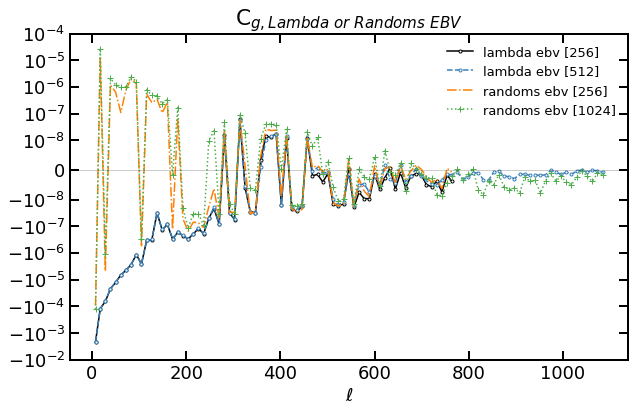

In [32]:
mk = ['.', '.', 'None', '+']
i = 0
# mitigated 
plt.figure(figsize=(10, 6))
for n_i, cl_i in cl_data.items():
    plt.plot(*cl_i, label=n_i, marker=mk[i], mfc='w')
    i += 1
    
plt.yscale('symlog', linthreshy=1.0e-8)
plt.ylim(-1.0e-2, 1.0e-4)
plt.legend()
plt.axhline(0.0, lw=1, alpha=0.2)
plt.xlabel(r'$\ell$')
plt.title(r'C$_{g,Lambda~or~Randoms~EBV}$')
# plt.xscale('log')